In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
PRISM_PATH = "/home/paul/Downloads/prism-games-3.2.1-linux64-x86/bin/prism"  # path to PRISM-games install
STRATEGY_PATH = "/home/paul/Documents/probabilistic_games/adv.tra" # path to where strategies shall be stored
STORE_PATH = "/home/paul/Downloads/prism-games-3.2.1-linux64-x86/generated/" # path to where generated models can be stored
QUERY_PATH = "/home/paul/Downloads/prism-games-3.2.1-linux64-x86/generated/queries/" # path to queries
OUTPUT_PATH = "/home/paul/Downloads/prism-games-3.2.1-linux64-x86/generated/outputs/" # path to PRISM-games generated output files

In [3]:
from journepy.src.preprocessing.bpic17 import preprocessed_log
from journepy.src.alergia_utils import convert_utils
from journepy.src.mc_utils.prism_utils import PrismPrinter
from journepy.src.mc_utils.prism_utils import PrismQuery

import probabilistic_game_utils as pgu 

from aalpy.learning_algs import run_Alergia
from aalpy.utils import save_automaton_to_file
from IPython.display import Image


import pandas as pd

from networkx.drawing.nx_agraph import to_agraph

import json

import networkx as nx

import subprocess

import matplotlib.pyplot as plt

# Load Data
We load the event log and additionally needed information.

In [4]:
filtered_log_before, filtered_log_after = preprocessed_log("data/BPI Challenge 2017.xes") # uses common preprocessing

/home/paul/.local/lib/python3.10/site-packages/pm4py/util/dt_parsing/parser.py:77: UserWarning: ISO8601 strings are not fully supported with strpfromiso for Python versions below 3.11
  warnings.warn(
/home/paul/.local/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
parsing log, completed traces :: 100%|██████████| 31509/31509 [00:50<00:00, 625.93it/s]


In [5]:
print(len(filtered_log_before))
print(len(filtered_log_after))

5515
6989


In [6]:
# change from xes format
def parse(s):
    return s.replace('(', ')').replace(')', '').replace(' ', '')
filtered_log_before_activities = [[parse(e['concept:name']) for e in t] for t in filtered_log_before]
filtered_log_after_activities = [[parse(e['concept:name']) for e in t] for t in filtered_log_after]

In [7]:
# load actor mapping: maps events to an actor (service provider or user)
with open('data/activities.xml') as f:
    data = f.read()
actors = json.loads(data)
actors = {parse(k) : parse(actors[k]) for k in actors}

In [8]:
# build action mapping: assigns each event to an actor
actions_to_activities = {}
actions_observed = set()
for trace in filtered_log_before_activities:
    actions_observed.update(trace)

actors_observed_actions = {}
for action in actions_observed:
    contained = [a for a in actors if a in action]
    print(action, contained)
    assert len(contained) == 1# each once - skip enumerating
    if actors[contained[0]] == "company": # events where company is NOT deterministic
        if 'O_Sentonlineonly' in action or 'O_Sentmailandonline' in action: 
            # sent online vs sent mail seems to be critical interaction - if aggregated together and diff. from others- 90%
            actions_to_activities[action] = "sent"
        elif 'O_CreateOffer0' in action:
            actions_to_activities[action] = action
        elif 'O_CreateOffer1' in action:
            actions_to_activities[action] = action
        elif 'O_CreateOffer2' in action:
            actions_to_activities[action] = action
        elif 'O_CreateOffer3' in action:
            actions_to_activities[action] = action
        elif 'O_CreateOffer4' in action:
            actions_to_activities[action] = action
        elif 'O_CreateOffer5' in action:
            actions_to_activities[action] = action
        elif 'A_Denied' in action:
            actions_to_activities[action] = action
        elif 'A_Incomplete' in action:
            actions_to_activities[action] = action
        elif 'A_Validating' in action:
            actions_to_activities[action] = action
        else:
            actions_to_activities[action] = action
    else:
        if "A_Submitted" in action: # event where user is deterministic
            actions_to_activities[action] = action
        elif "Callafteroffers" in action: # event where user is deterministic
            actions_to_activities[action] = "call"
        elif "Callincomplete" in action: # event where user is deterministic
            actions_to_activities[action] = "call"
        else: # includes "negative" action
            actions_to_activities[action] = "user"

    actors_observed_actions[action] = actors[contained[0]]

actors_observed_actions['offer'] = 'company'
actors_observed_actions['company'] = 'company'
actors_observed_actions['user'] = 'customer'
actors_observed_actions['sent'] = 'company'
actors_observed_actions['offer_response'] = 'company'
actors_observed_actions['callafter'] = 'customer'
actors_observed_actions['callincomplete'] = 'customer'

O_Returned ['O_Returned']
O_Accepted ['O_Accepted']
A_Submitted ['A_Submitted']
negative ['negative']
positive ['positive']
A_Accepted ['A_Accepted']
A_Concept ['A_Concept']
A_Validating ['A_Validating']
A_CancelledCUSTOMER ['A_CancelledCUSTOMER']
W_CallincompletefilesSHORT ['W_Callincompletefiles']
W_CallafteroffersSHORT ['W_Callafteroffers']
O_CreateOffer2 ['O_CreateOffer']
W_CallincompletefilesLONG ['W_Callincompletefiles']
start ['start']
W_CallafteroffersLONG ['W_Callafteroffers']
W_CallafteroffersSUPERLONG ['W_Callafteroffers']
O_Sentmailandonline ['O_Sentmailandonline']
W_CallincompletefilesSUPERLONG ['W_Callincompletefiles']
A_CreateApplication ['A_CreateApplication']
A_Pending ['A_Pending']
O_Cancelled ['O_Cancelled']
TIMEOUT ['TIMEOUT']
O_CreateOffer3 ['O_CreateOffer']
O_CreateOffer1 ['O_CreateOffer']
O_CreateOffer0 ['O_CreateOffer']
O_Sentonlineonly ['O_Sentonlineonly']


## Passive automata learning
The event log is transformed into an Input/Output format and environment actions to select the next player are added additionally.
Alergia learning automatically selects IO/Alergia if input is in [O, (I,O), ...] format.

In [9]:
# add activities
data_before = [[(actions_to_activities[t[i]], t[i]) for i in range(1, len(t))] for t in filtered_log_before_activities]
for d in data_before:
    d.insert(0, 'start')

data_after = [[(actions_to_activities[t[i]], t[i]) for i in range(1, len(t))] for t in filtered_log_after_activities]
for d in data_after:
    d.insert(0, 'start')

In [10]:
# quantify environment -> becomes MDP
data_before_environment = []
for trace in data_before:
    current = [trace[0]]
    for i in range(1, len(trace)):
        e = trace[i]
        previous_state = "start" if i == 1 else trace[i-1][1]
        
        # encode decision in one step
        current.append(('env', actors_observed_actions[e[1]] + previous_state))
        current.append(e)
    data_before_environment.append(current)

data_after_environment = []
for trace in data_after:
    current = [trace[0]]
    for i in range(1, len(trace)):
        e = trace[i]
        previous_state = "start" if i == 1 else trace[i-1][1]
        
        # encode decision in one step
        current.append(('env', actors_observed_actions[e[1]] + previous_state))
        current.append(e)
    data_after_environment.append(current)

In [11]:
model_before_environment = run_Alergia(data_before_environment, automaton_type='mdp', eps=0.8, print_info=True) # 0.1 plot interesting, 0.8 is confirms knowledge, 1.2 : plot align, 2 grows stronger, 1.8 : 2 is worse, grows stronger, gas is bit more interesting
model_after_environment = run_Alergia(data_after_environment, automaton_type='mdp', eps=0.8, print_info=True)

PTA Construction Time:  0.11
Alergia Learning Time: 0.09
Alergia Learned 95 state automaton.
PTA Construction Time:  0.12
Alergia Learning Time: 0.22
Alergia Learned 131 state automaton.


In [12]:
filename = "out/bpic_17-1_environment_actions"
save_automaton_to_file(model_before_environment, f"{filename}.dot")
save_automaton_to_file(model_before_environment, f"{filename}.png", file_type="png")

Model saved to out/bpic_17-1_environment_actions.dot.
Model saved to out/bpic_17-1_environment_actions.png.


In [13]:
filename = "out/bpic_17-2_environment_actions"
save_automaton_to_file(model_after_environment, f"{filename}.dot")
save_automaton_to_file(model_after_environment, f"{filename}.png", file_type="png")

Model saved to out/bpic_17-2_environment_actions.dot.
Model saved to out/bpic_17-2_environment_actions.png.


## Convert MDP to Game in Networkx format

In [14]:
g_before = convert_utils.mdp_to_nx(model_before_environment, actors_observed_actions)
g_after = convert_utils.mdp_to_nx(model_after_environment, actors_observed_actions)

In [15]:
g_before = pgu.add_gas_and_user_count(g_before, data_before_environment)
g_after = pgu.add_gas_and_user_count(g_after, data_after_environment)

In [16]:
# test on deterministic cycles:
def assert_no_det_cycle(g):
    for c in list(nx.simple_cycles(g)):
        found = False
        for i in range(len(c)):
            if g[c[i]][c[(i+1)%len(c)]]['prob_weight'] != 1:
                found = True
        assert found
assert_no_det_cycle(g_before)
assert_no_det_cycle(g_after)

# Model Checking Stochastic User Journey Games
The games are written to the prism format and PRISM-games is called.

In [17]:
printer_before = PrismPrinter(g_before, STORE_PATH, "bpic_17_1_alergia.prism")
printer_before.write_to_prism()
printer_after = PrismPrinter(g_after, STORE_PATH, "bpic_17_2_alergia.prism")
printer_after.write_to_prism()

In [18]:
query_before = PrismQuery(g_before, STORE_PATH, "bpic_17_1_alergia.prism", PRISM_PATH)
model_name_before = STORE_PATH+"bpic_17_1_alergia.prism"

query_after = PrismQuery(g_after, STORE_PATH, "bpic_17_2_alergia.prism", PRISM_PATH)
model_name_after = STORE_PATH+"bpic_17_2_alergia.prism"

In [19]:
# Query Q1 from Table 1
results_file_before = query_before.query(QUERY_PATH+"pos_alergia.props", write_parameterized=True)
print(results_file_before['q0start'])

results_file_after = query_after.query(QUERY_PATH+"pos_alergia.props", write_parameterized=True)
print(results_file_after['q0start'])

0.8865074490124265
0.9166362285809062


In [20]:
# Query Q2, Q3, and Q4 from Table 1 - BPIC'17-1
subprocess.run([PRISM_PATH, model_name_before, QUERY_PATH+"mc_runs.props", "-const", "envprob=0"]) 

PRISM-games

Version: 3.2.1 (based on PRISM 4.8.dev)
Date: Wed Sep 18 11:29:27 CEST 2024
Hostname: hp
Memory limits: cudd=1g, java(heap)=1g
Command line: prism-games /home/paul/Downloads/prism-games-3.2.1-linux64-x86/generated/bpic_17_1_alergia.prism /home/paul/Downloads/prism-games-3.2.1-linux64-x86/generated/queries/mc_runs.props -const envprob=0

Parsing model file "/home/paul/Downloads/prism-games-3.2.1-linux64-x86/generated/bpic_17_1_alergia.prism"...

Type:        SMG
Modules:     userModule providerModule controll
Variables:   gas state negative positive final_gas steps min_gas

Parsing properties file "/home/paul/Downloads/prism-games-3.2.1-linux64-x86/generated/queries/mc_runs.props"...

3 properties:
(1) <<providerPlayer,userPlayer>>R{"gas_neg"}min=? [ F (positive|negative) ]
(2) <<providerPlayer>>R{"gas_neg"}min=? [ F (positive|negative) ]
(3) <<providerPlayer>>R{"gas_pos"}max=? [ F (positive|negative) ]

---------------------------------------------------------------------


CompletedProcess(args=['/home/paul/Downloads/prism-games-3.2.1-linux64-x86/bin/prism', '/home/paul/Downloads/prism-games-3.2.1-linux64-x86/generated/bpic_17_1_alergia.prism', '/home/paul/Downloads/prism-games-3.2.1-linux64-x86/generated/queries/mc_runs.props', '-const', 'envprob=0'], returncode=0)

In [21]:
# Query Q2, Q3, and Q4 from Table 1 - BPIC'17-2
subprocess.run([PRISM_PATH, model_name_after, QUERY_PATH+"mc_runs.props", "-const", "envprob=0"]) 

PRISM-games

Version: 3.2.1 (based on PRISM 4.8.dev)
Date: Wed Sep 18 11:29:28 CEST 2024
Hostname: hp
Memory limits: cudd=1g, java(heap)=1g
Command line: prism-games /home/paul/Downloads/prism-games-3.2.1-linux64-x86/generated/bpic_17_2_alergia.prism /home/paul/Downloads/prism-games-3.2.1-linux64-x86/generated/queries/mc_runs.props -const envprob=0

Parsing model file "/home/paul/Downloads/prism-games-3.2.1-linux64-x86/generated/bpic_17_2_alergia.prism"...

Type:        SMG
Modules:     userModule providerModule controll
Variables:   gas state negative positive final_gas steps min_gas

Parsing properties file "/home/paul/Downloads/prism-games-3.2.1-linux64-x86/generated/queries/mc_runs.props"...

3 properties:
(1) <<providerPlayer,userPlayer>>R{"gas_neg"}min=? [ F (positive|negative) ]
(2) <<providerPlayer>>R{"gas_neg"}min=? [ F (positive|negative) ]
(3) <<providerPlayer>>R{"gas_pos"}max=? [ F (positive|negative) ]

---------------------------------------------------------------------


CompletedProcess(args=['/home/paul/Downloads/prism-games-3.2.1-linux64-x86/bin/prism', '/home/paul/Downloads/prism-games-3.2.1-linux64-x86/generated/bpic_17_2_alergia.prism', '/home/paul/Downloads/prism-games-3.2.1-linux64-x86/generated/queries/mc_runs.props', '-const', 'envprob=0'], returncode=0)

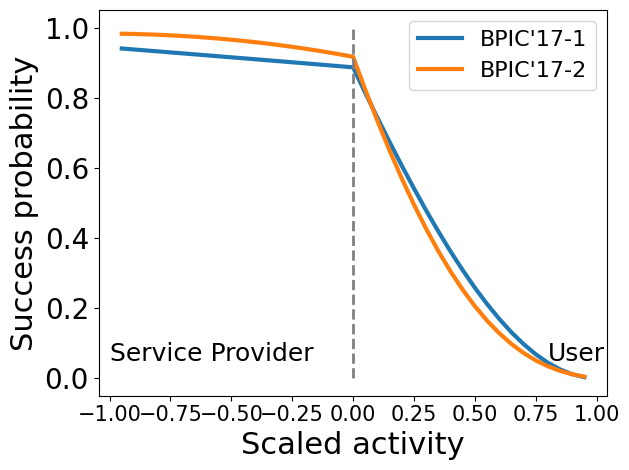

In [22]:
# run Activity experiment and produce Fig. 7
# remove "stdout=subprocess.DEVNULL" to print output again
file_name = OUTPUT_PATH+"succ_prop_cond-bpic-17-1.txt"
subprocess.run([PRISM_PATH, STORE_PATH+"bpic_17_1_alergia.prism",
                 QUERY_PATH+"pos_alergia.props",
                   "-const", "envprob=-0.95:0.05:0.95", "-exportresults", file_name+":dataframe"], stdout=subprocess.DEVNULL) 

df_visual = pd.read_csv(file_name)
plt.plot(df_visual['envprob'], df_visual['Result'], label = "BPIC'17-1", linewidth=3)

file_name = OUTPUT_PATH+"succ_prop_cond-bpic-17-2.txt"
subprocess.run([PRISM_PATH, STORE_PATH+"bpic_17_2_alergia.prism",
                 QUERY_PATH+"pos_alergia.props",
                   "-const", "envprob=-0.95:0.05:0.95", "-exportresults", file_name+":dataframe"], stdout=subprocess.DEVNULL) 

df_visual = pd.read_csv(file_name)
plt.plot(df_visual['envprob'], df_visual['Result'], label = "BPIC'17-2", linewidth=3)

plt.vlines(x=0, ymin=0, ymax = 1, linewidth=2, color = 'grey', linestyles='--')
plt.text(-1, 0.05, 'Service Provider', fontsize = 18)
plt.text(0.8, 0.05, 'User', fontsize = 18)
plt.legend(fontsize=16)
plt.xlabel("Scaled activity", fontsize=22)
plt.ylabel("Success probability", fontsize=22)
plt.xticks(fontsize=15)
plt.yticks(fontsize=20)
plt.tight_layout()
plt.savefig("out/bpic_activity_comparison.png", dpi=300)
plt.show()

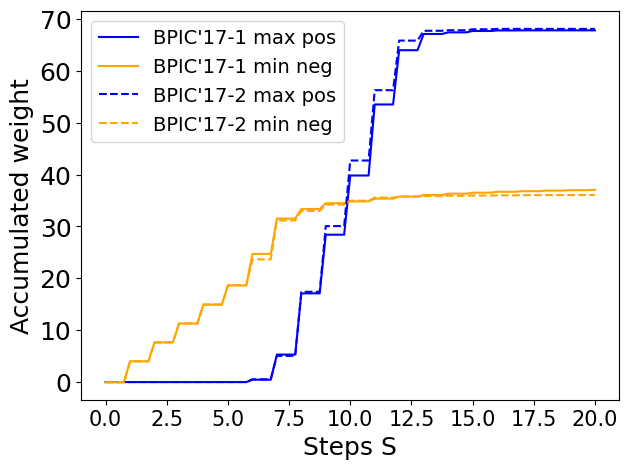

In [23]:
# run gas upper and lower bound under limited steps
PrismPrinter(g_before, STORE_PATH, "bpic_17_1_alergia.prism").write_to_prism(write_extended_parameterized=True)
file_name_pos = OUTPUT_PATH+"steps_gas_pos_bound-bpic-17-1.txt"
subprocess.run([PRISM_PATH, model_name_before, 
                QUERY_PATH+"reward_props.props", "-prop", "3",
                "-const", "m0=0,m1=0:1:80,m2=0,", "-exportresults", file_name_pos+":dataframe"], stdout=subprocess.DEVNULL) 
file_name_neg = OUTPUT_PATH+"steps_gas_neg_bound-bpic-17-1.txt"
subprocess.run([PRISM_PATH, model_name_before, 
                QUERY_PATH+"reward_props.props", "-prop", "4",
                "-const", "m0=0,m1=0:1:80,m2=0,", "-exportresults", file_name_neg+":dataframe"], stdout=subprocess.DEVNULL) 

df_visual = pd.read_csv(file_name_pos)
plt.plot(df_visual['m1']/4, df_visual['Result'], label="BPIC'17-1 max pos", c = "blue")
df_visual = pd.read_csv(file_name_neg)
plt.plot(df_visual['m1']/4, df_visual['Result'], label="BPIC'17-1 min neg", c = "orange")

PrismPrinter(g_after, STORE_PATH, "bpic_17_2_alergia.prism").write_to_prism(write_extended_parameterized=True)
file_name_pos = OUTPUT_PATH+"steps_gas_pos_bound-bpic-17-2.txt"
subprocess.run([PRISM_PATH, model_name_after, 
                QUERY_PATH+"reward_props.props", "-prop", "3",
                "-const", "m0=0,m1=0:1:80,m2=0,", "-exportresults", file_name_pos+":dataframe"], stdout=subprocess.DEVNULL) 
file_name_neg = OUTPUT_PATH+"steps_gas_neg_bound-bpic-17-2.txt"
subprocess.run([PRISM_PATH, model_name_after, 
                QUERY_PATH+"reward_props.props", "-prop", "4",
                "-const", "m0=0,m1=0:1:80,m2=0,", "-exportresults", file_name_neg+":dataframe"], stdout=subprocess.DEVNULL) 

df_visual = pd.read_csv(file_name_pos)
plt.plot(df_visual['m1']/4, df_visual['Result'], label="BPIC'17-2 max pos", c = "blue", linestyle="dashed")
df_visual = pd.read_csv(file_name_neg)
plt.plot(df_visual['m1']/4, df_visual['Result'], label="BPIC'17-2 min neg", c = "orange", linestyle="dashed")

plt.legend(fontsize=14)
plt.xlabel("Steps S", fontsize=18)
plt.ylabel("Accumulated weight", fontsize=18)
plt.xticks(fontsize=15)
plt.yticks(fontsize=18)
plt.tight_layout()
plt.savefig("out/bpic_17_steps.png", dpi=300)
plt.show()

## Induced and Reduced Model
We generate a strategy for Q1 and build the induced Markov chain. 

In [24]:
query_before = PrismQuery(g_before, STORE_PATH, "bpic_17_1_alergia.prism", PRISM_PATH)
query_after = PrismQuery(g_after, STORE_PATH, "bpic_17_2_alergia.prism", PRISM_PATH)

In [25]:
strategy_before = query_before.get_strategy(QUERY_PATH+"pos_alergia.props")

skipped ['q19O_Sentmailandonline']
skipped ['q20O_Sentonlineonly']
skipped ['q28customerO_Sentonlineonly']
skipped ['q27companyO_Sentonlineonly']
skipped ['q35O_CreateOffer1']
skipped ['q42O_Sentmailandonline']
skipped ['q37W_CallafteroffersSHORT']
skipped ['q36W_CallafteroffersLONG']
skipped ['q38W_CallafteroffersSUPERLONG']
skipped ['q40W_CallafteroffersSHORT']
skipped ['q59O_Sentmailandonline']
skipped ['q45companyO_CreateOffer1']
skipped ['q46companyW_CallafteroffersLONG']
skipped ['q47customerW_CallafteroffersLONG']
skipped ['q48companyW_CallafteroffersSHORT']
skipped ['q49customerW_CallafteroffersSHORT']
skipped ['q51customerW_CallafteroffersSUPERLONG']
skipped ['q50companyW_CallafteroffersSUPERLONG']
skipped ['q53customerW_CallafteroffersSHORT']
skipped ['q56customerO_Sentmailandonline']
skipped ['q55companyO_Sentmailandonline']
skipped ['q57O_Sentmailandonline']
skipped ['q83O_CreateOffer2']
skipped ['q60A_Validating']
skipped ['q61O_Cancelled']
skipped ['q63W_CallafteroffersSH

In [26]:
strategy_after = query_after.get_strategy(QUERY_PATH+"pos_alergia.props")

skipped ['q19O_Sentmailandonline']
skipped ['q20O_Sentonlineonly']
skipped ['q27customerO_Sentmailandonline']
skipped ['q28customerO_Sentonlineonly']
skipped ['q46companyO_Sentonlineonly']
skipped ['q33O_Sentmailandonline']
skipped ['q34O_Sentonlineonly']
skipped ['q62O_Sentmailandonline']
skipped ['q37W_CallafteroffersSHORT']
skipped ['q36W_CallafteroffersLONG']
skipped ['q38W_CallafteroffersSUPERLONG']
skipped ['q41O_CreateOffer1']
skipped ['q43O_Sentmailandonline']
skipped ['q45customerO_Sentmailandonline']
skipped ['q49companyW_CallafteroffersLONG']
skipped ['q50customerW_CallafteroffersLONG']
skipped ['q51companyW_CallafteroffersSHORT']
skipped ['q52customerW_CallafteroffersSHORT']
skipped ['q54customerW_CallafteroffersSUPERLONG']
skipped ['q53companyW_CallafteroffersSUPERLONG']
skipped ['q56companyO_CreateOffer1']
skipped ['q60customerO_Sentmailandonline']
skipped ['q59companyO_Sentmailandonline']
skipped ['q101O_Sentmailandonline']
skipped ['q63W_CallafteroffersSHORT']
skipped [

In [27]:
def can_be_merged(g, results_file):
    for s in g.nodes():
        reachable_values = [round(results_file[t],4) for t in g[s]]
        if round(results_file[s],4) in reachable_values:
        #if len(set(reachable_values)) == 1 and reachable_values[0] == round(results_file[s],2):
            return s 
    return None

"""
NOTE: One positive and one negative node is kept and all remaining from positive/negative cluster are merged into them.
"""
def reduce_graph(g, results_file):
    neg_cluster = []
    pos_cluster = []
    print("size start", len(g.nodes()))
    s = can_be_merged(g, results_file)
    while(s != None):
        for t in g[s]:
            if round(results_file[t],4) != round(results_file[s],4):
                continue
            g = nx.contracted_nodes(g, s, t, self_loops = False)
        s = can_be_merged(g, results_file)

    for s in g:
        if results_file[s] == 0:
            neg_cluster.append(s)
        if results_file[s] == 1:
            pos_cluster.append(s)
    for s in pos_cluster[1:]:
        g = nx.contracted_nodes(g, pos_cluster[0], s, self_loops=False)
    for s in neg_cluster[1:]:
        g = nx.contracted_nodes(g, neg_cluster[0], s, self_loops=False)

    g.remove_edges_from(nx.selfloop_edges(g))

    print("size reduced", len(g.nodes()))
    return g

In [28]:
from  matplotlib.colors import LinearSegmentedColormap # for color map
from matplotlib.colors import rgb2hex

def compute_color_map(g, results_file):
    c = ["#D55E00", "#F0E442", "#009E73"]
    v = [0,0.5,1]
    l = list(zip(v,c))
    cmap=LinearSegmentedColormap.from_list('rg',l, N=256)
    s = cmap(0.23)
    map = {}
    for s in g.nodes():
        map[s] = rgb2hex(cmap(results_file[s])) # have to convert to hex color
    return map

def draw_dfg(g, name, names={}, layout = "sfdp", color_map = []):
    """
    Helper function to draw Networkx graphs.
    """
    scaling = 10
    # build graph with variable thickness
    #scaling = 1/np.mean(list(nx.get_edge_attributes(g,'edge_weight').values()))

    A = to_agraph(g)

    edge_weights = nx.get_edge_attributes(g,'edge_weight')
    for e in edge_weights:
        e = A.get_edge(e[0], e[1])
        e.attr["penwidth"] = edge_weights[e]*scaling
        e.attr["fontsize"] = "20"
    for e in g.edges:
        edge = A.get_edge(e[0], e[1])
        if 'controllable' in g[e[0]][e[1]]:
            if not g[e[0]][e[1]]['controllable']:
                edge.attr["style"] = "dotted"
                #edge.attr["label"] =  str(g[e[0]][e[1]]["prob_weight"])
        #A.add_edge(e[0], e[1], penwidth = edge_weights[e]*scaling)

    #A.graph_attr.update(size="7.75,10.25")

    for n in A.nodes():
        if n in names:
            new = names[n]
            if isinstance(names[n], float): 
                new = round(names[n], 2)
            n.attr['label'] = new
            #if new == 1:
            #    n.attr['label'] = "pos"
            #elif new == 0:
            #    n.attr['label'] = "neg"
            #else:
            #    n.attr["label"] = "" # uncomment to print state names
        if n in color_map:
            n.attr['color'] = color_map[n]
    
        n.attr['fontsize'] = 120
        n.attr['penwidth'] = 30
        n.attr['height'] = 3
        n.attr['width'] = 3

    for e in A.edges():
        e.attr['penwidth'] = 20
        e.attr["fontsize"] = 120
        e.attr["label"] = str(round(g[e[0]][e[1]]["prob_weight"],2))
        e.attr["color"] = "black"

        if g[e[0]][e[1]]['gas'] > 0:
            e.attr["color"] ="darkgreen"
        if g[e[0]][e[1]]['gas'] < 0:
            e.attr["color"] ="red"
             
    A.write(name.split(".")[0]+".dot")
    A.layout(layout)
    A.draw(name)
    print("Plotted", name)

In [29]:
def get_probs_file(results_file, g, printer):
    isomophism = nx.vf2pp_isomorphism(printer.g, g, node_label=None)
    parsed_results_file = {isomophism[r] : results_file[r] for r in results_file}
    return parsed_results_file

color_map = compute_color_map(g_before, get_probs_file(results_file_before, g_before, printer_before))

extended_naming = []
draw_dfg(g_before, "out/before_clustered.png", names=extended_naming, layout = "dot", color_map=color_map)
#draw_dfg(g_before, "out/alergia_bpic_17-1_probs.png", get_probs_file(results_file, g_before), layout = "dot") # plots graph with marked probabilities, but takes some time to render

Plotted out/before_clustered.png


/home/paul/.local/lib/python3.10/site-packages/pygraphviz/agraph.py:1407: RuntimeWarning: neato: graph is too large for cairo-renderer bitmaps. Scaling by 0.997959 to fit

  warnings.warn(b"".join(errors).decode(self.encoding), RuntimeWarning)


In [30]:
# Produces Figure 6 (1) and (2)
import copy
def plot_reduction(g, name, results_file, layout = "sdf"):
    g = copy.deepcopy(g)
    g = reduce_graph(g, results_file)
    color_map = compute_color_map(g, results_file)
    draw_dfg(g, name, names = results_file, layout = layout, color_map=color_map)
plot_reduction(g_before, "out/alergia_bpic_17-1_probs_reduced.png", get_probs_file(results_file_before, g_before, printer_before), layout = "dot")
plot_reduction(g_after, "out/alergia_bpic_17-2_probs_reduced.png", get_probs_file(results_file_after, g_after, printer_after), layout = "dot")

size start 95
size reduced 32


Plotted out/alergia_bpic_17-1_probs_reduced.png
size start 131
size reduced 47
Plotted out/alergia_bpic_17-2_probs_reduced.png


### Constrained steps and parameterized transitions

In [31]:
# estimate max counts before
subprocess.run([PRISM_PATH, model_name_before, QUERY_PATH+"exp_values.props"]) 

PRISM-games

Version: 3.2.1 (based on PRISM 4.8.dev)
Date: Wed Sep 18 11:31:06 CEST 2024
Hostname: hp
Memory limits: cudd=1g, java(heap)=1g
Command line: prism-games /home/paul/Downloads/prism-games-3.2.1-linux64-x86/generated/bpic_17_1_alergia.prism /home/paul/Downloads/prism-games-3.2.1-linux64-x86/generated/queries/exp_values.props

Parsing model file "/home/paul/Downloads/prism-games-3.2.1-linux64-x86/generated/bpic_17_1_alergia.prism"...

Type:        SMG
Modules:     userModule providerModule controll
Variables:   gas state negative positive final_gas steps min_gas

Parsing properties file "/home/paul/Downloads/prism-games-3.2.1-linux64-x86/generated/queries/exp_values.props"...

3 properties:
(1) <<providerPlayer>>R{"steps"}max=? [ Fc positive ]
(2) <<providerPlayer>>R{"gas_neg"}max=? [ Fc positive ]
(3) <<providerPlayer>>R{"gas_pos"}max=? [ Fc positive ]

---------------------------------------------------------------------

Model checking: <<providerPlayer>>R{"steps"}max=? [ F

CompletedProcess(args=['/home/paul/Downloads/prism-games-3.2.1-linux64-x86/bin/prism', '/home/paul/Downloads/prism-games-3.2.1-linux64-x86/generated/bpic_17_1_alergia.prism', '/home/paul/Downloads/prism-games-3.2.1-linux64-x86/generated/queries/exp_values.props'], returncode=0)

In [32]:
# estimate max counts after
subprocess.run([PRISM_PATH, model_name_after, QUERY_PATH+"exp_values.props"]) 

PRISM-games

Version: 3.2.1 (based on PRISM 4.8.dev)
Date: Wed Sep 18 11:31:08 CEST 2024
Hostname: hp
Memory limits: cudd=1g, java(heap)=1g
Command line: prism-games /home/paul/Downloads/prism-games-3.2.1-linux64-x86/generated/bpic_17_2_alergia.prism /home/paul/Downloads/prism-games-3.2.1-linux64-x86/generated/queries/exp_values.props

Parsing model file "/home/paul/Downloads/prism-games-3.2.1-linux64-x86/generated/bpic_17_2_alergia.prism"...

Type:        SMG
Modules:     userModule providerModule controll
Variables:   gas state negative positive final_gas steps min_gas

Parsing properties file "/home/paul/Downloads/prism-games-3.2.1-linux64-x86/generated/queries/exp_values.props"...

3 properties:
(1) <<providerPlayer>>R{"steps"}max=? [ Fc positive ]
(2) <<providerPlayer>>R{"gas_neg"}max=? [ Fc positive ]
(3) <<providerPlayer>>R{"gas_pos"}max=? [ Fc positive ]

---------------------------------------------------------------------

Model checking: <<providerPlayer>>R{"steps"}max=? [ F

CompletedProcess(args=['/home/paul/Downloads/prism-games-3.2.1-linux64-x86/bin/prism', '/home/paul/Downloads/prism-games-3.2.1-linux64-x86/generated/bpic_17_2_alergia.prism', '/home/paul/Downloads/prism-games-3.2.1-linux64-x86/generated/queries/exp_values.props'], returncode=0)

In [33]:
steps_max_before = 40#int(62/2)
max_gas_before = int(68/2)
min_gas_before = 50 #int(1080/10)

steps_max_after = 40 #int(76/2)
max_gas_after = int(68/2)
min_gas_after = 50 #int(1323/17)

In [34]:
# Query Q1 on bounded model BPIC'17-1
query = PrismQuery(g_before, STORE_PATH, "bpic_17_1_alergia_param.prism", PRISM_PATH)
results_file = query.query(QUERY_PATH+"pos_alergia.props", 
                           write_attributes=True, write_parameterized=True, envprob=0, 
                           steps_max=steps_max_before, min_gas=-min_gas_before, max_gas=max_gas_before)
results_file['q0start']

0.886508297569364

In [35]:
# Query Q1 on bounded model BPIC'17-2
query = PrismQuery(g_after, STORE_PATH, "bpic_17_2_alergia_param.prism", PRISM_PATH)
results_file = query.query(QUERY_PATH+"pos_alergia.props", 
                           write_attributes=True, write_parameterized=True, envprob=0, 
                           steps_max=steps_max_after, min_gas=-max_gas_after, max_gas=max_gas_after)
results_file['q0start']

0.916636228569082

In [36]:
# experiment over gas (m0), steps (m1), and min_gas (m2)
# Takes some time to execute
PrismPrinter(g_before, STORE_PATH, "bpic_17_1_alergia_param.prism").write_to_prism(write_extended_parameterized=True, 
                                                                                   write_attributes=True, steps_max=steps_max_before, min_gas=-min_gas_before, max_gas=max_gas_before)
# file_name = OUTPUT_PATH+"bounded_steps_gas_min_gas_bpic_17-1.txt"
# subprocess.run([PRISM_PATH, STORE_PATH+"bpic_17_1_alergia_param.prism", 
#                 QUERY_PATH+"bounded_props.props",
#                 "-const", "m0=32:1:36,m1=12:10:32,m2=-35:5:-15,", "-exportresults", file_name+":dataframe"])


In [37]:
PrismPrinter(g_after, STORE_PATH, "bpic_17_2_alergia_param.prism").write_to_prism(write_extended_parameterized=True,
                                                                                  write_attributes=True, steps_max=steps_max_after, min_gas=-min_gas_after, max_gas=max_gas_after)
# file_name = OUTPUT_PATH+"bounded_steps_gas_min_gas_bpic_17-2.txt"
# subprocess.run([PRISM_PATH, STORE_PATH+"bpic_17_2_alergia_param.prism", 
#                 QUERY_PATH+"bounded_props.props",
#                 "-const", "m0=32:1:36,m1=12:10:32,m2=-35:5:-15,", "-exportresults", file_name+":dataframe"])

(0.12, 0.77, 0.85) [(32, -35), (33, -35), (34, -35)]
34 -35
(0.12, 0.33, 0.35) [(32, -30), (32, -25), (33, -30), (33, -25), (34, -30), (34, -25)]
34 -25
(0.01, 0.03, 0.03) [(32, -20), (33, -20), (34, -20)]
34 -20
(0.0, 0.0, 0.0) [(32, -15), (33, -15), (34, -15), (35, -35), (35, -30), (35, -25), (35, -20), (35, -15), (36, -35), (36, -30), (36, -25), (36, -20), (36, -15)]
36 -15
(0.19, 0.87, 0.89) [(32, -35), (33, -35), (34, -35)]
34 -35
(0.19, 0.35, 0.36) [(32, -30), (33, -30), (34, -30)]
34 -30
(0.19, 0.34, 0.35) [(32, -25), (33, -25), (34, -25)]
34 -25
(0.02, 0.04, 0.04) [(32, -20), (33, -20), (34, -20)]
34 -20
(0.0, 0.0, 0.0) [(32, -15), (33, -15), (34, -15), (35, -35), (35, -30), (35, -25), (35, -20), (35, -15), (36, -35), (36, -30), (36, -25), (36, -20), (36, -15)]
36 -15


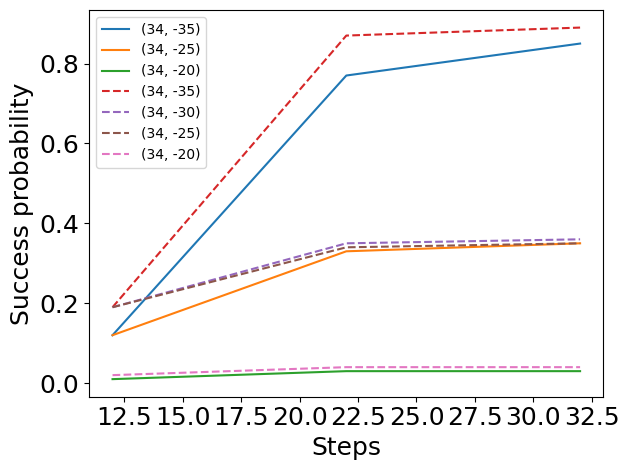

In [38]:
# bounded reachability plot for BPIC'17
def plot_df(df, dashed = False):
    df_visual_grouped = df.groupby(['m0','m2'])
    result_dict = {}
    for g in df_visual_grouped.groups.keys():
        r = tuple([round(h,2) for h in df_visual_grouped.get_group(g)['Result'].values])
        if r in result_dict:
            result_dict[r].append(g)
        else:
            result_dict[r] = [g]

    for k in result_dict:
        g = result_dict[k]
        max_m0 = max(h[0] for h in result_dict[k])
        max_m2 = max(h[1] for h in result_dict[k])
        print(k, result_dict[k])
        print(max_m0, max_m2)
        assert((max_m0, max_m2) in result_dict[k])
        if len(set(k)) != 1:
            if dashed:
                plt.plot(df_visual_grouped.get_group((max_m0, max_m2))['m1'], k, label = str((max_m0, max_m2)), linestyle="dashed")
            else:
                plt.plot(df_visual_grouped.get_group((max_m0, max_m2))['m1'], k, label = str((max_m0, max_m2)))

file_name = OUTPUT_PATH+"bounded_steps_gas_min_gas_bpic_17-1.txt"
df_visual = pd.read_csv(file_name)
plot_df(df_visual)

file_name = OUTPUT_PATH+"bounded_steps_gas_min_gas_bpic_17-2.txt"
df_visual = pd.read_csv(file_name)
plot_df(df_visual, dashed=True)

plt.legend(fontsize=10)
plt.xlabel("Steps", fontsize=18)
plt.ylabel("Success probability", fontsize=18)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.tight_layout()
plt.savefig("out/bpic_bounded.png", dpi=300)

## Improvement recommendation ranking

In [39]:
strategy_before = query_before.get_strategy(QUERY_PATH+"pos_alergia.props")
strategy_before

skipped ['q19O_Sentmailandonline']
skipped ['q20O_Sentonlineonly']
skipped ['q28customerO_Sentonlineonly']
skipped ['q27companyO_Sentonlineonly']
skipped ['q35O_CreateOffer1']
skipped ['q42O_Sentmailandonline']
skipped ['q37W_CallafteroffersSHORT']
skipped ['q36W_CallafteroffersLONG']
skipped ['q38W_CallafteroffersSUPERLONG']
skipped ['q40W_CallafteroffersSHORT']
skipped ['q59O_Sentmailandonline']
skipped ['q45companyO_CreateOffer1']
skipped ['q46companyW_CallafteroffersLONG']
skipped ['q47customerW_CallafteroffersLONG']
skipped ['q48companyW_CallafteroffersSHORT']
skipped ['q49customerW_CallafteroffersSHORT']
skipped ['q51customerW_CallafteroffersSUPERLONG']
skipped ['q50companyW_CallafteroffersSUPERLONG']
skipped ['q53customerW_CallafteroffersSHORT']
skipped ['q56customerO_Sentmailandonline']
skipped ['q55companyO_Sentmailandonline']
skipped ['q57O_Sentmailandonline']
skipped ['q83O_CreateOffer2']
skipped ['q60A_Validating']
skipped ['q61O_Cancelled']
skipped ['q63W_CallafteroffersSH

{'q0start': 'env',
 'q1companystart': 'A_CreateApplication',
 'q2A_CreateApplication': 'env',
 'q4customerA_CreateApplication': 'A_Submitted',
 'q3companyA_CreateApplication': 'A_Concept',
 'q5A_Concept': 'env',
 'q6A_Submitted': 'env',
 'q7companyA_Concept': 'A_Accepted',
 'q8companyA_Submitted': 'A_Concept',
 'q9A_Accepted': 'env',
 'q10A_Concept': 'env',
 'q11companyA_Accepted': 'O_CreateOffer0',
 'q12companyA_Concept': 'A_Accepted',
 'q13O_CreateOffer0': 'env',
 'q14A_Accepted': 'env',
 'q15companyO_CreateOffer0': 'O_CreateOffer1',
 'q16customerO_CreateOffer0': 'user',
 'q17companyA_Accepted': 'O_CreateOffer0',
 'q18O_CreateOffer1': 'env',
 'q21A_CancelledCUSTOMER': 'env',
 'q22O_Cancelled': 'env',
 'q23O_CreateOffer0': 'env',
 'q24companyO_CreateOffer1': 'sent',
 'q54customerO_CreateOffer1': 'user',
 'q26customerO_Sentmailandonline': 'user',
 'q25companyO_Sentmailandonline': 'A_Validating',
 'q29customerA_CancelledCUSTOMER': 'user',
 'q30companyO_Cancelled': 'O_CreateOffer2',
 'q6

In [40]:
strategy_after = query_after.get_strategy(QUERY_PATH+"pos_alergia.props")
strategy_after

skipped ['q19O_Sentmailandonline']
skipped ['q20O_Sentonlineonly']
skipped ['q27customerO_Sentmailandonline']
skipped ['q28customerO_Sentonlineonly']
skipped ['q46companyO_Sentonlineonly']
skipped ['q33O_Sentmailandonline']
skipped ['q34O_Sentonlineonly']
skipped ['q62O_Sentmailandonline']
skipped ['q37W_CallafteroffersSHORT']
skipped ['q36W_CallafteroffersLONG']
skipped ['q38W_CallafteroffersSUPERLONG']
skipped ['q41O_CreateOffer1']
skipped ['q43O_Sentmailandonline']
skipped ['q45customerO_Sentmailandonline']
skipped ['q49companyW_CallafteroffersLONG']
skipped ['q50customerW_CallafteroffersLONG']
skipped ['q51companyW_CallafteroffersSHORT']
skipped ['q52customerW_CallafteroffersSHORT']
skipped ['q54customerW_CallafteroffersSUPERLONG']
skipped ['q53companyW_CallafteroffersSUPERLONG']
skipped ['q56companyO_CreateOffer1']
skipped ['q60customerO_Sentmailandonline']
skipped ['q59companyO_Sentmailandonline']
skipped ['q101O_Sentmailandonline']
skipped ['q63W_CallafteroffersSHORT']
skipped [

{'q0start': 'env',
 'q1companystart': 'A_CreateApplication',
 'q2A_CreateApplication': 'env',
 'q4customerA_CreateApplication': 'A_Submitted',
 'q3companyA_CreateApplication': 'A_Concept',
 'q5A_Concept': 'env',
 'q6A_Submitted': 'env',
 'q7companyA_Concept': 'A_Accepted',
 'q8companyA_Submitted': 'A_Concept',
 'q9A_Accepted': 'env',
 'q10A_Concept': 'env',
 'q11companyA_Accepted': 'O_CreateOffer0',
 'q12companyA_Concept': 'A_Accepted',
 'q13O_CreateOffer0': 'env',
 'q14A_Accepted': 'env',
 'q15companyO_CreateOffer0': 'O_CreateOffer1',
 'q16customerO_CreateOffer0': 'user',
 'q17companyA_Accepted': 'O_CreateOffer0',
 'q18O_CreateOffer1': 'env',
 'q22O_Cancelled': 'env',
 'q21A_CancelledCUSTOMER': 'env',
 'q39TIMEOUT': 'env',
 'q23O_CreateOffer0': 'env',
 'q24companyO_CreateOffer1': 'O_CreateOffer2',
 'q25customerO_CreateOffer1': 'user',
 'q26companyO_Sentmailandonline': 'A_Validating',
 'q29customerA_CancelledCUSTOMER': 'user',
 'q30companyO_Cancelled': 'sent',
 'q31companyO_CreateOffer

## BPIC'17 Sankey Diagram

In [41]:
def transform_strategy(strategy, g, printer):
    """ 
    Adjusts the strategy naming from PRISM node naming to original node naming in g
    """
    isomorphism = nx.vf2pp_isomorphism(printer.g, g, node_label=None)
    strategy_isomorphism = {k[len(isomorphism[k].split(": ")[0]):] : ": ".join(isomorphism[k].split(": ")[1:]) for k in isomorphism}
    parsed_strategy = {isomorphism[r] : strategy_isomorphism[strategy[r]] if strategy[r] not in ["env", "user", "company", "sent", "call"] else strategy[r] for r in strategy}
    assert(len(parsed_strategy)==len(strategy))
    return parsed_strategy

def lost_users(g, results_file, strategy):
    lost_users_dict = {}
    total_lost_users_dict = {}
    for s in strategy:
        assert s in g
        next_states = [t for t in g[s] if g[s][t]['action'] == strategy[s]]

        assert(next_states)
        total_lost_users = 0
        for t in next_states:
            action_outcome_cost = len(g[s][t]['trace_indices']) * abs(round(results_file[s],4)-round(results_file[t],4))
            lost_users_dict[(s,t)] = action_outcome_cost

            total_lost_users += action_outcome_cost
                
        if total_lost_users != 0:
            total_lost_users_dict[s] = total_lost_users
    total = sum(total_lost_users_dict.values())
    print("total", total)
    for k in (sorted( ((v,k) for k,v in total_lost_users_dict.items()), reverse=True)):
        print(k, k[0]/total)
    print(sorted(lost_users_dict.values(), reverse=True))
    return lost_users_dict
lost_users_dict_before = lost_users(g_before, get_probs_file(results_file_before, g_before, printer_before), transform_strategy(strategy_before, g_before, printer_before))

total 128.30570000000003
(35.636199999999974, 'q33: O_Sentmailandonline') 0.2777444805647759
(34.08, 'q79: customerW_CallincompletefilesSHORT') 0.26561563515884323
(16.15219999999989, 'q23: O_CreateOffer0') 0.12588840558135678
(12.139899999999983, 'q13: O_CreateOffer0') 0.09461699675072877
(11.4897, 'q16: customerO_CreateOffer0') 0.08954941206820895
(7.3456, 'q77: customerW_CallincompletefilesLONG') 0.057250769061701845
(3.299900000000002, 'q22: O_Cancelled') 0.02571904443839986
(2.3569, 'q68: customerO_Cancelled') 0.018369409932684204
(2.0507000000001665, 'q2: A_CreateApplication') 0.015982922036980166
(1.7941999999999942, 'q71: W_CallincompletefilesLONG') 0.013983790275880134
(1.2792000000000088, 'q18: O_CreateOffer1') 0.009969938981666508
(0.3160000000000107, 'q65: customerO_Returned') 0.0024628679785856015
(0.26600000000000845, 'q72: W_CallincompletefilesSHORT') 0.002073173678176483
(0.09920000000000329, 'q75: customerA_Validating') 0.000773153492011682
[17.818199999999973, 17.818,

In [42]:
import plotly.graph_objects as go

def flatten(d, l):
      """
      Helper function to get contracted nodes dict.
      """
      for e in d:
            l.append(e)
            if 'contraction' in d[e]:
                  flatten(d[e]['contraction'], l)
      return l

def reduced_sankey_diagram(g, results_file, strategy, lost_users_dict):
      g = copy.deepcopy(g)
      print(strategy.keys())
      g = g.subgraph(strategy.keys()) # consider only nodes seen in strategy
      g = reduce_graph(g, results_file)
      color_map = compute_color_map(g, results_file)

      d = nx.get_node_attributes(g, "contraction")
      reduction_mapping = {}
      for k in d:
            reduction_mapping[k] = flatten(d[k], [])
      print("reduction mapping", reduction_mapping)
                             
      node_list = list(g.nodes())
      print("Node_list", node_list)
      print(len(node_list))
      node_dict = {node_list[i] : i for i in range(len(node_list))}

      print("lost users dict", lost_users_dict)

      edge_list = []
      value_list = []
      for e in [e for e in lost_users_dict if lost_users_dict[e] != 0]:
            if e[0] in node_list:
                  s = e[0]
            else:
                  s = None
                  for h in reduction_mapping:
                        if e[0] in reduction_mapping[h]:
                              s = h
                  assert s
            if e[1] in node_list:
                  t = e[1]
            else:
                  t = None
                  for h in reduction_mapping:
                        if e[1] in reduction_mapping[h]:
                              t = h
                  assert t
            edge_list.append((s,t))
            value_list.append(lost_users_dict[e])

      labels = []
      
      # build label list with right states
      for s in node_list:
            if s not in reduction_mapping or s in lost_users_dict:
                  label = str(s).split(": ")[1].replace("LONG", "").replace("SHORT", "").replace("W_", "").replace("Callincompletefiles", 'Call incomplete files')
                  labels.append(label)
            elif any(["start" in h for h in reduction_mapping[s]]):
                  labels.append("Start")
            elif any(["q30" in h for h in reduction_mapping[s]]) or "q30" in s:
                  labels.append("Sent (mail and online)")
            elif any(["q23" in h for h in reduction_mapping[s]]) or "q23" in s:
                  labels.append("Create Offer 0")
            elif any(["q13" in h for h in reduction_mapping[s]]) or "q13" in s:
                  labels.append("Create Offer 0")
            elif results_file[s] == 1:
                  labels.append("succ")
            elif results_file[s] == 0:
                  labels.append("unsucc")
            else:
                  # s is in reduction_mapping and not in lost_users_dict
                  labels.append("")
                  #labels.append("C"+str(s).split(": ")[0])

      fig = go.Figure(data=[go.Sankey(
      node = dict(
          pad = 5,
          thickness = 30,
          line = dict(color = "black", width = 0.5),
          label = labels,
          color = [color_map[s] for s in node_list],
          align = "right"
      ),
      link = dict(
          source = [node_dict[e[0]] for e in edge_list],
          target = [node_dict[e[1]] for e in edge_list],
          value = value_list,
          arrowlen=15,
      ))])
      fig.update_layout(
        font=dict(size = 30)
    )
      fig.write_image("out/before_sankey.png")
      fig.show()


reduced_sankey_diagram(g_before, get_probs_file(results_file_before, g_before, printer_before), transform_strategy(strategy_before, g_before, printer_before), lost_users_dict_before)

dict_keys(['q0: start', 'q1: companystart', 'q2: A_CreateApplication', 'q4: customerA_CreateApplication', 'q3: companyA_CreateApplication', 'q5: A_Concept', 'q6: A_Submitted', 'q7: companyA_Concept', 'q8: companyA_Submitted', 'q9: A_Accepted', 'q10: A_Concept', 'q11: companyA_Accepted', 'q12: companyA_Concept', 'q13: O_CreateOffer0', 'q14: A_Accepted', 'q15: companyO_CreateOffer0', 'q16: customerO_CreateOffer0', 'q17: companyA_Accepted', 'q18: O_CreateOffer1', 'q21: A_CancelledCUSTOMER', 'q22: O_Cancelled', 'q23: O_CreateOffer0', 'q24: companyO_CreateOffer1', 'q54: customerO_CreateOffer1', 'q26: customerO_Sentmailandonline', 'q25: companyO_Sentmailandonline', 'q29: customerA_CancelledCUSTOMER', 'q30: companyO_Cancelled', 'q68: customerO_Cancelled', 'q31: companyO_CreateOffer0', 'q33: O_Sentmailandonline', 'q32: O_CreateOffer2', 'q34: A_Validating', 'q82: O_CreateOffer3', 'q39: TIMEOUT', 'q86: O_Cancelled', 'q43: companyO_CreateOffer2', 'q44: companyA_Validating', 'q52: customerTIMEOUT'

In [43]:
lost_users_dict_after = lost_users(g_after, get_probs_file(results_file_after, g_after, printer_after), transform_strategy(strategy_after, g_after, printer_after))

total 252.42059999999964
(124.98580000000001, 'q64: O_Sentmailandonline') 0.49514896961658517
(31.464500000000047, 'q109: customerW_CallincompletefilesSHORT') 0.1246510783985146
(27.15919999999985, 'q13: O_CreateOffer0') 0.10759502195938005
(22.321199999999756, 'q23: O_CreateOffer0') 0.08842859893368366
(12.212500000000002, 'q42: O_CreateOffer1') 0.04838155047567441
(12.014899999999995, 'q2: A_CreateApplication') 0.04759873005610482
(7.652000000000003, 'q108: customerW_CallincompletefilesLONG') 0.030314483049323288
(3.3796, 'q16: customerO_CreateOffer0') 0.013388764625391132
(3.0944999999999983, 'q18: O_CreateOffer1') 0.012259300548370468
(2.2316000000000056, 'q99: W_CallincompletefilesLONG') 0.008840799839632775
(2.1107000000000014, 'q32: O_CreateOffer2') 0.00836183734608033
(1.2427000000000041, 'q79: customerO_Returned') 0.004923132264165468
(1.0996999999999535, 'q95: W_CallincompletefilesSHORT') 0.00435661748684519
(0.6542000000000012, 'q94: W_CallincompletefilesLONG') 0.00259170606

In [44]:
def reduced_sankey_diagram(g, results_file, strategy, lost_users_dict):
      g = copy.deepcopy(g)
      print(strategy.keys())
      g = g.subgraph(strategy.keys()) # consider only nodes seen in strategy
      g = reduce_graph(g, results_file)
      color_map = compute_color_map(g, results_file)

      d = nx.get_node_attributes(g, "contraction")
      reduction_mapping = {}
      for k in d:
            reduction_mapping[k] = flatten(d[k], [])
      print("reduction mapping", reduction_mapping)
                             
      node_list = list(g.nodes())
      print("Node_list", node_list)
      print(len(node_list))
      node_dict = {node_list[i] : i for i in range(len(node_list))}

      print("dict", lost_users_dict)

      edge_list = []
      value_list = []
      for e in [e for e in lost_users_dict if lost_users_dict[e] != 0]:
            if e[0] in node_list:
                  s = e[0]
            else:
                  s = None
                  for h in reduction_mapping:
                        if e[0] in reduction_mapping[h]:
                              s = h
                  assert s
            if e[1] in node_list:
                  t = e[1]
            else:
                  t = None
                  for h in reduction_mapping:
                        if e[1] in reduction_mapping[h]:
                              t = h
                  assert t
            edge_list.append((s,t))
            value_list.append(lost_users_dict[e])

      labels = []

      # build label list with right states
      for s in node_list:
            if s not in reduction_mapping or s in lost_users_dict:
                  label = str(s).split(": ")[1].replace("LONG", "").replace("SHORT", "").replace("W_", "").replace("Callincompletefiles", 'Call incomplete files')
                  labels.append(label)
            elif any(["start" in h for h in reduction_mapping[s]]):
                  labels.append("Start")
            elif any(["q64" in h for h in reduction_mapping[s]]) or "q64" in s:
                  labels.append("Sent (mail and online)")
            elif any(["q23" in h for h in reduction_mapping[s]]) or "q23" in s:
                  labels.append("Create Offer 0")
            elif any(["q13" in h for h in reduction_mapping[s]]) or "q13" in s:
                  labels.append("Create Offer 0")
            elif any(["q42" in h for h in reduction_mapping[s]]) or "q42" in s:
                  labels.append("Create Offer 1")
            elif any(["q32" in h for h in reduction_mapping[s]]) or "q42" in s:
                  labels.append("Create Offer 2")
            elif results_file[s] == 1:
                  labels.append("succ")
            elif results_file[s] == 0:
                  labels.append("unsucc")
            else:
                  # s is in reduction_mapping and not in lost_users_dict
                  labels.append("")
                  #labels.append("C"+str(s).split(": ")[0])

      fig = go.Figure(data=[go.Sankey(
      node = dict(
          pad = 10,
          thickness = 30,
          line = dict(color = "black", width = 0.5),
          label = labels,
          color = [color_map[s] for s in node_list],
          align = "right"
      ),
      link = dict(
          source = [node_dict[e[0]] for e in edge_list],
          target = [node_dict[e[1]] for e in edge_list],
          value = value_list,
          arrowlen=15,
      ))])
      fig.update_layout(
        font=dict(size = 30)
    )
      fig.write_image("out/after_sankey.png")
      fig.show()

reduced_sankey_diagram(g_after, get_probs_file(results_file_after, g_after, printer_after),  transform_strategy(strategy_after, g_after, printer_after), lost_users_dict_after)

dict_keys(['q0: start', 'q1: companystart', 'q2: A_CreateApplication', 'q4: customerA_CreateApplication', 'q3: companyA_CreateApplication', 'q5: A_Concept', 'q6: A_Submitted', 'q7: companyA_Concept', 'q8: companyA_Submitted', 'q9: A_Accepted', 'q10: A_Concept', 'q11: companyA_Accepted', 'q12: companyA_Concept', 'q13: O_CreateOffer0', 'q14: A_Accepted', 'q15: companyO_CreateOffer0', 'q16: customerO_CreateOffer0', 'q17: companyA_Accepted', 'q18: O_CreateOffer1', 'q22: O_Cancelled', 'q21: A_CancelledCUSTOMER', 'q39: TIMEOUT', 'q23: O_CreateOffer0', 'q24: companyO_CreateOffer1', 'q25: customerO_CreateOffer1', 'q26: companyO_Sentmailandonline', 'q29: customerA_CancelledCUSTOMER', 'q30: companyO_Cancelled', 'q31: companyO_CreateOffer0', 'q32: O_CreateOffer2', 'q35: A_Validating', 'q64: O_Sentmailandonline', 'q42: O_CreateOffer1', 'q44: companyO_CreateOffer2', 'q87: customerO_CreateOffer2', 'q47: companyA_Validating', 'q48: customerA_Validating', 'q55: customerTIMEOUT', 'q57: companyO_CreateO

In [45]:
def total_lost_users(g):
    for s in g:
        if "negative" in s:
            print("neg", sum([len(set(g.edges[e]['trace_indices'])) for e in g.in_edges(s)]))
        if "positive" in s:
            print("pos", sum([len(set(g.edges[e]['trace_indices'])) for e in g.in_edges(s)]))

total_lost_users(g_before)

neg 2907
pos 2608
